# Data Simulation - Author: Andrew Scott

The goal of this notebook is to demonstrate how to create a new dataset that simulates existing real-world data using Python. This notebook will contain Python code and its outputs, as well as text that expands upon the code. Wherever code requires a reference, a link to the reference will be provided in the code comments. References in the text will be numbered and a reference section at the end of this notebook will provide further information about the source. 

# Table of Contents
* [**Cats Dataset**](#h1)
* [**Using Numpy's Random Module to Generate Simulated Data**](#h2)
* [**Simulating Correlated Data with Numpy's multivariate_normal() Module**](#h3)
* [**Separating the Dataset Based on Sex**](#h4)
    * [**Further Analysis of the Original Data**](#h5)
    * [**Testing for Normal Distribution**](#h6)
* [**Generating Simulated Data for Each Sex**](#h7)
* [**Adding Additional Variable Columns**](#h8)
* [**A Function to Generate a Simulated Cats Dataset**](#h9)
* [**Removing Underweight Samples**](#h10)
* [**Dealing with the Truncated Distribution of Female Body Weight**](#h11)
* [**Conclusion**](#h12)
* [**References**](#h13)

In [1]:
# Packages used throughout the notebook

# Package for numerical calculations and arrays
import numpy as np

# Accessing datasets
import statsmodels.api as sm

# For dataframes
import pandas as pd

# Generating plots
import matplotlib.pyplot as plt

# Generating plots 
import seaborn as sns

# For accessing dates and times
import datetime as dt

# A magic command for helping display matplotlib plots in notebooks
%matplotlib inline

Below is a function that will be used to display statistical information about the simulated data and the original data side-by-side for easy comparison. 

In [2]:
# Function to display outputs from different dfs in one output
# Code from Anton Golubev: 
# https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

-----

## Cats Dataset<a id='h1'></a>

The dataset being simulated is a dataset that was originally published by Ronald Fisher that consists of cats and their gender, body weight, and heart weight[<sup>1</sup>](#f1).<a id='a1'></a> The dataset is part of the MASS package for the programming language R. However, these datasets can be accessed in Python using the statsmodel package[<sup>2</sup>](#f2).<a id='a2'></a>

In [3]:
# Load the cats dataset 
cats = sm.datasets.get_rdataset(dataname='cats', package='MASS')

In [4]:
# Print some information about the dataset 
print(cats.__doc__)

.. container::

   ==== ===============
   cats R Documentation
   ==== ===============

   .. rubric:: Anatomical Data from Domestic Cats
      :name: anatomical-data-from-domestic-cats

   .. rubric:: Description
      :name: description

   The heart and body weights of samples of male and female cats used
   for *digitalis* experiments. The cats were all adult, over 2 kg body
   weight.

   .. rubric:: Usage
      :name: usage

   ::

      cats

   .. rubric:: Format
      :name: format

   This data frame contains the following columns:

   ``Sex``
      sex: Factor with levels ``"F"`` and ``"M"``.

   ``Bwt``
      body weight in kg.

   ``Hwt``
      heart weight in g.

   .. rubric:: Source
      :name: source

   R. A. Fisher (1947) The analysis of covariance method for the
   relation between a part and the whole, *Biometrics* **3**, 65–68.

   .. rubric:: References
      :name: references

   Venables, W. N. and Ripley, B. D. (2002) *Modern Applied Statistics
   with S.* F

The documentation above states that the weight of a cat's heart and body is useful for "digitalis experiments". This refers to the drug digoxin, also known as digitalis, which is used to treat various heart conditions[<sup>3</sup>](#f3).<a id='a3'></a> A strong relationship between body weight and heart weight would mean that body weight could be used to calculate the dose that a cat should receive, as body weight is easier to directly measure than heart weight. This is how dosage is currently calculated, with the recommended dosage being "0015 -0.002 mg/lbs every 12 hours for cats"[<sup>4</sup>](#f4).<a id='a4'></a> 

Due to the risk of toxicity by giving the wrong dose, simulation can be useful to provide an estimate for the rate of rare occurrences, such as how often should we expect to see a cat with a high body weight and a low heart weight, which may require adjustments in dosages. 

In [5]:
# Load the cats dataset to a pandas dataframe
df_cats = cats.data

In [6]:
# View the first few rows of the dataframe
df_cats.head()

,Sex,Bwt,Hwt
0,F,2.0,7.0
1,F,2.0,7.4
2,F,2.0,9.5
3,F,2.1,7.2
4,F,2.1,7.3


In [7]:
# View the shape of the dataframe
df_cats.shape

(144, 3)

In [8]:
# View summary statistics of dataframe
orig_summ = df_cats.describe()
orig_summ

,Bwt,Hwt
count,144.000000,144.000000
mean,2.723611,10.630556
std,0.485307,2.434636
min,2.000000,6.300000
25%,2.300000,8.950000
50%,2.700000,10.100000
75%,3.025000,12.125000
max,3.900000,20.500000


In [9]:
# Show the amount of male and female cats in the dataset
df_cats['Sex'].value_counts()

M    97
F    47
Name: Sex, dtype: int64

The above summaries give an overview as to the dimensions and datatypes involved. There are three variable types - a binary male/female column, and two numerical columns containing body weights and heart weights. We will have to invent a fourth column when simulating this dataset to meet the criteria of the simulated dataset having at least four variables. 

Datetime will be used when saving dataframes and plots to give each file a unique filename containing the current time when the file was saved. 

There will be dataframes and plots generated in this notebook that will not be backed up to avoid folders getting overly cluttered. Some are useful to be displayed within the notebook for demonstrative purposes but are not as important overall as those backed up. 

In [10]:
# Save the original dataset
# Access the current date and time.
now = dt.datetime.now()

# Formatting the current date and time as a string and saving to a variable.
current_time = now.strftime('%Y%m%d_%H%M%S')

# A path to save the dataframe, using dt to create unique file names
path = 'cats-dataset/cats-original-data/cats_original_dataset/cats_original_'  + current_time + '.csv'

# Save pandas data frame to disk.
df_cats.to_csv(path)

------

## Using Numpy's Random Module to Generate Simulated Data<a id='h2'></a>

Values such as animal weights commonly follow a normal distribution, where the most common weight is the mean, and weights become more and more uncommon the further they get from the mean in either direction[<sup>5</sup>](#f5).<a id='a5'></a> Ignoring the sex for now and focusing on the numerical values, we could generate some random body weight and heart weight data using numpy by assuming a normal distribution for both variables, and using the summary statistics as a basis for the random data.

In [11]:
# Construct a new Generator with the default BitGenerator (PCG64)
# Seeded for reproducible results
rng = np.random.default_rng(seed = 501)

# Numpy randomly generated bwt with defined mean and std
# 100 random samples from a normal distribution
mu = 2.723611
sigma = 0.485307
random_bwt = rng.normal(mu, sigma, size=100)
random_bwt

array([2.17930379, 2.8431481 , 2.58133273, 2.59291175, 3.07554702,
       3.0397276 , 3.23124009, 2.53951761, 2.54360903, 3.15743213,
       3.29549089, 1.90281974, 2.3432193 , 2.593383  , 2.81058881,
       2.19762536, 3.03754655, 2.69848523, 3.19382971, 2.61704186,
       3.02988841, 2.24868163, 1.84241256, 2.8658994 , 2.95768856,
       1.29199448, 2.93591153, 1.86295528, 2.86961876, 2.61109233,
       2.86935197, 3.36814523, 3.04395907, 2.35416663, 2.50633595,
       3.35781195, 2.48054651, 2.93788186, 1.9561881 , 3.73832929,
       2.45700317, 2.10373047, 2.31305787, 2.55667255, 1.88387285,
       2.14499153, 2.88014605, 2.10001704, 2.9114496 , 2.50124325,
       2.57483043, 2.64137358, 2.83579697, 2.4796103 , 2.29659046,
       2.50352536, 1.86356256, 2.42191691, 3.18094962, 2.75987015,
       2.97608982, 2.2216094 , 2.39047272, 2.69899322, 2.48979544,
       2.41736389, 2.29241721, 2.34977951, 2.28580472, 2.49622027,
       2.18661026, 2.6883948 , 2.49648407, 2.5500638 , 2.74314

In [12]:
# Numpy randomly generated bwt with defined mean and std
# 100 random samples from a normal distribution
mu = 10.630556
sigma = 2.434636
random_hwt = rng.normal(mu, sigma, size=100)
random_hwt

array([10.70327711, 13.40663078, 12.84970519, 14.56471838,  6.10888679,
       10.26866323,  3.39810752, 13.09217136, 12.91101626,  7.6739178 ,
       11.22223463, 13.47122407, 11.99775933, 10.22979087, 13.33225091,
        8.04155487,  9.02562462, 15.08476254,  9.25996586,  7.31613876,
       14.87259583, 10.33293915, 10.15928348, 11.15132039, 10.99798703,
        8.96461709,  8.89837108,  5.21569666,  7.67256412,  9.04706882,
        6.89324895,  6.24879464,  9.71492776, 13.22696129,  7.07036394,
        6.42732728, 10.4120992 , 10.15191115, 10.84750728, 13.39416132,
        7.61068531,  7.6880468 ,  8.14014958, 12.80379584, 13.04108787,
       10.70800049,  8.98488646,  8.30251315,  6.92052211, 10.44207291,
       12.81688662,  9.24665373, 11.11225172, 11.83328487,  7.12443517,
       10.82509563, 15.50113951,  9.24621924,  9.00823422, 14.27518224,
        9.17547483, 10.39830593, 11.38067027, 10.55205973,  9.65653148,
       12.43183373,  7.61768863,  9.30786842, 13.87582411, 10.33

In [13]:
# Create a new df with the random np arrays
# code adapted from:
# https://stackoverflow.com/questions/29949757/creating-pandas-dataframe-between-two-numpy-arrays-then-draw-scatter-plot
random_df = pd.DataFrame({'random_bwt':random_bwt, 'random_hwt':random_hwt})
random_df

,random_bwt,random_hwt
0,2.179304,10.703277
1,2.843148,13.406631
2,2.581333,12.849705
3,2.592912,14.564718
4,3.075547,6.108887
...,...,...
95,2.297118,14.534721
96,2.955009,7.306640
97,1.845317,9.370722
98,1.662017,9.155159


In [14]:
# View summary statistics
random_df.describe()

,random_bwt,random_hwt
count,100.000000,100.000000
mean,2.607563,10.381145
std,0.495739,2.627939
min,1.252891,3.398108
25%,2.309073,8.805568
50%,2.578082,10.333246
75%,2.942164,12.341540
max,4.394208,17.077299


We can see from the summary statistics that our random dataframe has somewhat similar summary statistics to the original. Despite this, it is not an acceptable simulation of the original dataset. This will become apparent by plotting scatterplots of the original data and the random data.

Text(0.5, 1.0, 'Original Cats Data')

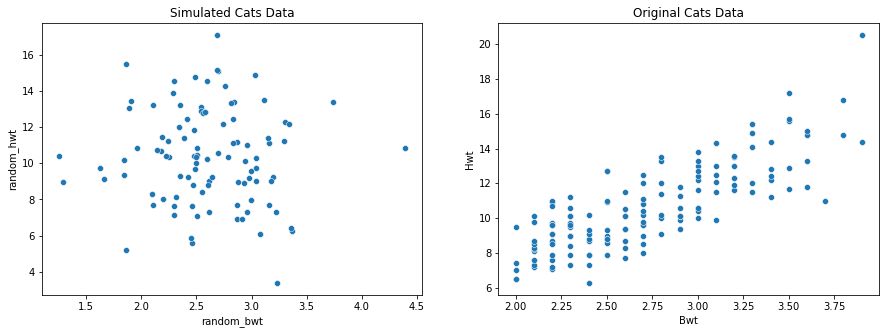

In [15]:
# sCATterplot of bwt and hwt
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axes[0], data = random_df, x = 'random_bwt', y= 'random_hwt')
axes[0].set_title('Simulated Cats Data')
sns.scatterplot(ax=axes[1], data = df_cats, x = 'Bwt', y= 'Hwt')
axes[1].set_title('Original Cats Data')


As we can see, there appears to be a positive correlation between a cat's body weight and heart weight, whereas in the random dataframe there is little correlation. This can also be shown numerically by calculating the correlation coefficient. This is a value of between -1 and +1, where -1 is a perfect negative correlation (as one value increases, the other decreases proportionally), +1 is a perfect positive correlation (as one value increases, the other increases proportionally) and 0 is no correlation (no discernible relationship between variables)[<sup>6</sup>](#f6).<a id='a6'></a>

In [16]:
# Get the correlation bodyweight and heartweight
orig_corr = df_cats.corr()
# Get the correlation bodyweight and heartweight
random_df_corr = random_df.corr()
# Show Correlations
display_side_by_side([random_df_corr, orig_corr], ['Simulation Correlation', 
                                                'Original Correlation'])

,random_bwt,random_hwt
random_bwt,1.000000,-0.055416
random_hwt,-0.055416,1.000000
,Bwt,Hwt
Bwt,1.000000,0.804127
Hwt,0.804127,1.000000


A positive correlation as with the original cats data means that in general, lighter cats have lighter hearts and heavier cats have heavier hearts. While 0.8 is a very strong correlation, it is not perfect. For example, here are some rare instances where a cat has a heavier heart than another cat that has a higher body weight. For that reason, it will not suffice to just sort the random values so that the lightest cat is matched with the lightest heart up to the heaviest cat and the heaviest heart.  

----

## Simulating Correlated Data with Numpy's multivariate_normal() Module<a id='h3'></a>

Since the data appears to be correlated, one potential solution is to assume that the data is normally distributed and then use numpy random's multivariate_normal method, which samples from multiple correlated normal distributions given the mean of the normal distributions and their covariance matrix[<sup>7</sup>](#f7).<a id='a7'></a>

In [17]:
# Create a df containing only the numerical bwt and hwt columns
df_cats_num = df_cats[['Bwt', 'Hwt']]

In [18]:
# Get covariance matrix of dataframe
df_cats_num.cov().to_numpy()

array([[0.23552253, 0.95011267],
       [0.95011267, 5.92745144]])

In [19]:
# Generate multivariate random data based on the original df mean, covariance, and size
mean = [2.723611, 10.630556]
cov = [[0.23552253, 0.95011267], [0.95011267, 5.92745144]]
size = 144

cats_mvn = rng.multivariate_normal(mean, cov, size)

In [20]:
# Convert random array to pandas df
df_cats_mvn = pd.DataFrame(cats_mvn, columns = ['Bwt', 'Hwt'])

In [21]:
# View description of random dataset
cats_mvn_summ = df_cats_mvn.describe()
display_side_by_side([cats_mvn_summ, orig_summ], ['Simulation Summary Statistics', 
                                                'Original Summary Statistics'])

,Bwt,Hwt
count,144.000000,144.000000
mean,2.727470,10.619237
std,0.426279,2.178917
min,1.756078,6.080195
25%,2.426996,8.997623
50%,2.743171,10.536973
75%,2.978730,12.087864
max,3.933044,17.655224
,Bwt,Hwt
count,144.000000,144.000000


Text(0.5, 1.0, 'Original Cats Data')

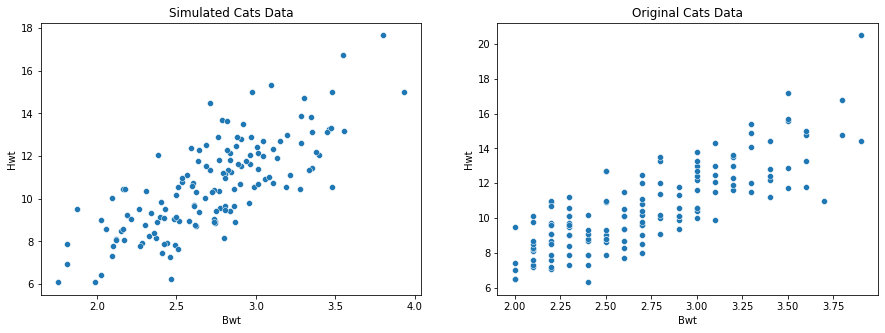

In [22]:
# Plot multivariate random data
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axes[0], data = df_cats_mvn, x = 'Bwt', y= 'Hwt')
axes[0].set_title('Simulated Cats Data')
sns.scatterplot(ax=axes[1], data = df_cats, x = 'Bwt', y= 'Hwt')
axes[1].set_title('Original Cats Data')

This random data certainly appears to be more in line with the original dataset. We could split the data above and below 3.0kg and assign a sex of male or female to the data below 3.0kg and all male to the data above 3.0, akin to the original dataset. However, it might be worthwhile to dive even deeper and see if there's a difference between the sexes that would be obscured by randomly generating both sexes at once as is done here.

----

## Separating the Dataset Based on Sex<a id='h4'></a>

As the sex of the cat may impact the other variables[<sup>8</sup>](#f8)<a id='a8'></a>, it would be a good idea to also look at the summary statistics for each sex. 

In [23]:
# Store dfs seperated by sex for use later in the notebook
orig_f = df_cats[df_cats['Sex'] == 'F']
orig_m = df_cats[df_cats['Sex'] == 'M']

# View summary statistics for each sex
# Code adapted from: https://stackoverflow.com/questions/42579148/get-columns-describe-from-group-by
orig_sex_summ = df_cats.groupby(['Sex']).describe()
orig_sex_summ

Bwt                                                 Hwt             \
    count      mean       std  min   25%  50%  75%  max count       mean   
Sex                                                                        
F    47.0  2.359574  0.273988  2.0  2.15  2.3  2.5  3.0  47.0   9.202128   
M    97.0  2.900000  0.467484  2.0  2.50  2.9  3.2  3.9  97.0  11.322680   

                                            
          std  min   25%   50%   75%   max  
Sex                                         
F    1.357666  6.3  8.35   9.1  10.1  13.0  
M    2.542288  6.5  9.40  11.4  12.8  20.5

A standard deviation gives us information about how spread that variable's values are[<sup>9</sup>](#f9).<a id='a9'></a> The standard deviations of the male values for body weight and heart weight are much higher than for females, suggesting there is typically a greater variation in male sizes, whereas females tend to be more similar in body and heart weights to one another. 

### Further Analysis of the Original Data<a id='h5'></a>

We can also look at the scatterplot again, this time colour-coded to differentiate the sex.

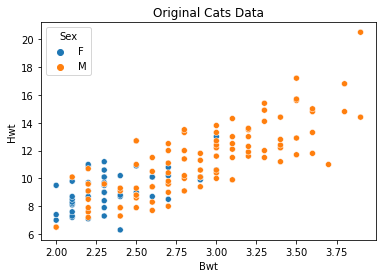

In [24]:
# sCATterplot of random bwt and hwt
sns.scatterplot(data = df_cats, x = 'Bwt', y= 'Hwt', hue = 'Sex').set_title('Original Cats Data')
# Save plot
path = 'cats-dataset/cats-original-data/cats_original_plots/cats_original_scatter'  + current_time + '.png'
plt.savefig(path)

It will be helpful to plot the dataset to visualise the distributions of each variable. It will help to decide if the assumption of normally distributed data is justified. If the distribution is bell-shaped, chances are the data is normally distributed.

Text(0.5, 1.0, 'Original Cats Data')

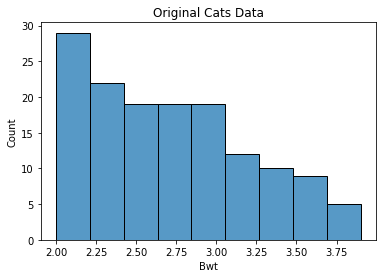

In [25]:
# Plotting the body weight of all cats
sns.histplot(data = df_cats, x = 'Bwt').set_title('Original Cats Data')

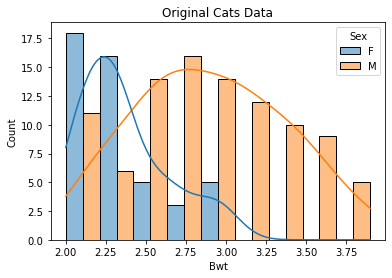

In [26]:
# Plotting the bodyweight by sex
sns.histplot(data = df_cats, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True).set_title('Original Cats Data')
# Save plot
path = 'cats-dataset/cats-original-data/cats_original_plots/cats_hist_bwt'  + current_time + '.png'
plt.savefig(path)

Text(0.5, 1.0, 'Original Cats Data')

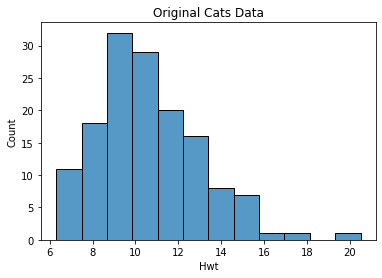

In [27]:
# Plotting the heart weight of all cats
sns.histplot(data = df_cats, x = 'Hwt').set_title('Original Cats Data')

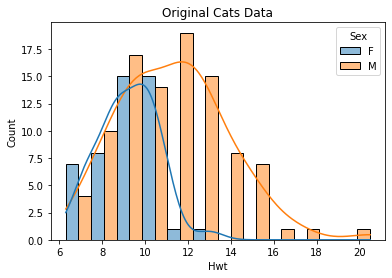

In [28]:
# Plotting the heart weight by sex
sns.histplot(data = df_cats, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True).set_title('Original Cats Data')
# Save plot
path = 'cats-dataset/cats-original-data/cats_original_plots/cats_hist_hwt'  + current_time + '.png'
plt.savefig(path)

Both the summary statistics and the plots suggest that sex influences the distribution of the variables. 
The male datapoints appear to come close to the bell-shaped curve of a normal distribution, whereas the female datapoints seem to skew slightly, and the curve stops suddenly on the left of the data.

It might be a good idea to create use our dataframes containing the data for each sex to look at the correlation between body weight and heart weight based on sex. 

In [29]:
# code adapted from:
# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values
# New df for each sex
df_cats_female = df_cats.loc[df_cats['Sex'] == 'F']
df_cats_male = df_cats.loc[df_cats['Sex'] == 'M']

In [30]:
# Correlation of original female sample
orig_f_corr = orig_f.corr()
orig_f_corr

,Bwt,Hwt
Bwt,1.00000,0.53205
Hwt,0.53205,1.00000


In [31]:
# Correlation of original male sample
orig_m_corr = orig_m.corr()
orig_m_corr

,Bwt,Hwt
Bwt,1.00000,0.79303
Hwt,0.79303,1.00000


It is interesting to note that while both males and females have a strong positive correlation between body weight and heart weight, the correlation is much higher in males than females.

### Testing for Normal Distribution<a id='h6'></a>

We can use a statistical test for normality, which will help us to decide if our assumption that the data is normally distributed is correct.

One such test is the Shapiro-Wilks test[<sup>10</sup>](#f10)<a id='a10'></a> which can be performed using the scipy.stats package[<sup>11</sup>](#f11).<a id='a11'></a> While there are numerous normality tests, the Shapiro–Wilk test is recommended when sample sizes are under 50, which is the case with female samples[<sup>12</sup>](#f12)<a id='a12'></a>. It can also be used for samples above 50, however, so it can also be used to test the male data also.

The Shapiro-Wilk tests a null hypothesis that the data comes from a normal distribution. If the p-value is greater than 0.05, then the test fails to reject that null hypothesis. 

In [32]:
from scipy.stats import shapiro

#perform Shapiro-Wilk test on male body weight
shapiro(df_cats_male['Bwt'])

ShapiroResult(statistic=0.9788321852684021, pvalue=0.11895745247602463)

In [33]:
#perform Shapiro-Wilk test on male heart weight
shapiro(df_cats_male['Hwt'])

ShapiroResult(statistic=0.9772655963897705, pvalue=0.09039346873760223)

In [34]:
#perform Shapiro-Wilk test on female body weight
shapiro(df_cats_female['Bwt'])

ShapiroResult(statistic=0.8909613490104675, pvalue=0.0003754299250431359)

In [35]:
#perform Shapiro-Wilk test on female heart weight
shapiro(df_cats_female['Hwt'])

ShapiroResult(statistic=0.9787967205047607, pvalue=0.5434856414794922)

These test results suggest that we can assume that male body weights, heart weights, and female heart weights were drawn from a normal distribution. However, the p-value for female body weights suggests that we can assume that this data is not normally distributed. This is unusual, because as shown earlier, weights are often normally distributed. This may be a false result due to the low sample size[<sup>13</sup>](#f13)<a id='a13'></a>, or it may be because all cats under 2kg were excluded from the original dataset thus leaving us with a truncated normal distribution[<sup>14</sup>](#f14).<a id='a14'></a>

For now, we will proceed as before and use numpy random's multivariate normal to generate data for each sex and see if it will generate a sample that sufficiently simulates the original, and later we can try alternative methods for data that is not normally distributed. 

-----

## Generating Simulated Data for Each Sex<a id='h7'></a>

Multivariate normal requires the covariance matrix as an argument to generate the random data. The covariance can be found using the .cov() method, and the values passed in an array format. We can generate data for females and males separately, and then combine the data to create a simulated dataset.

In [36]:
# Get covariance matrix for female cats
df_cats_female.cov()

,Bwt,Hwt
Bwt,0.075069,0.197914
Hwt,0.197914,1.843256


In [37]:
# Generate multivariate random data based on the original female df mean and covariance
mean_f = [2.359574, 9.202128]
cov_f = [[0.07506938, 0.19791397], [0.19791397, 1.84325624]]
size_f = 47 # Match the number of females from original dataset
female_cats_mvn = rng.multivariate_normal(mean_f, cov_f, size_f)

In [38]:
# Convert random array to pandas df
df_female_cats_mvn = pd.DataFrame(female_cats_mvn, columns = ['Bwt', 'Hwt'])

In [39]:
# View summary statistics of the random data
df_f_mvn_summ = df_female_cats_mvn.describe()
display_side_by_side([df_f_mvn_summ, orig_f.describe()], ['Simulation Summary Statistics Females', 
                                                'Original Summary Statistics Females'])

,Bwt,Hwt
count,47.000000,47.000000
mean,2.355740,8.946741
std,0.238650,1.403378
min,1.752350,5.908395
25%,2.186459,7.889774
50%,2.329810,9.025656
75%,2.525623,9.837076
max,2.867885,11.950115
,Bwt,Hwt
count,47.000000,47.000000


In [40]:
# Add a column with sex of female
df_female_cats_mvn['Sex'] = 'F'

In [41]:
# View beginning of dataframe
# Using head as otherwise the entire df is shown
df_female_cats_mvn.head()

,Bwt,Hwt,Sex
0,2.522447,8.297698,F
1,2.492555,10.402778,F
2,2.475531,8.502075,F
3,2.181832,9.183459,F
4,2.222886,9.146523,F


In [42]:
# Get covariance matrix for male cats
df_cats_male.cov()

,Bwt,Hwt
Bwt,0.218542,0.94250
Hwt,0.942500,6.46323


In [43]:
# Generate multivariate random data based on the original male df mean and covariance
mean_m = [2.900000, 11.322680]
cov_m = [[0.21854167, 0.9425], [0.9425, 6.46323024]]
size_m = 97 # Match the number of males from original dataset
male_cats_mvn = rng.multivariate_normal(mean_m, cov_m, size_m)

In [44]:
# Convert random array to pandas df
df_male_cats_mvn = pd.DataFrame(male_cats_mvn, columns = ['Bwt', 'Hwt'])

In [45]:
# View summary statistics of the random data
df_m_mvn_summ = df_male_cats_mvn.describe()
display_side_by_side([df_m_mvn_summ, orig_m.describe()], ['Simulation Summary Statistics Males', 
                                                'Original Summary Statistics Males'])

,Bwt,Hwt
count,97.000000,97.000000
mean,2.886138,11.232388
std,0.499029,2.752377
min,1.954291,4.725192
25%,2.490628,9.163956
50%,2.877611,11.037862
75%,3.203926,13.145520
max,4.308814,18.346890
,Bwt,Hwt
count,97.000000,97.000000


In [46]:
# Add a column with sex of female
df_male_cats_mvn['Sex'] = 'M'

In [47]:
# View dataframe
df_male_cats_mvn

,Bwt,Hwt,Sex
0,2.498770,8.974813,M
1,2.772193,12.212678,M
2,2.519866,9.472758,M
3,2.294579,9.163956,M
4,2.429634,8.741393,M
...,...,...,...
92,3.008427,10.004401,M
93,2.740933,12.272868,M
94,3.148222,10.524619,M
95,3.546292,14.367670,M


In [48]:
# ConCAT male and female dfs
all_cats_mvn = pd.concat([df_female_cats_mvn, df_male_cats_mvn])

Now we have all the simulated weight data in one dataframe, we can round the results to one decimal place and move the sex column to be the first column as was the case in the original dataset. 

In [49]:
# Round the values of the random df to one decimal place as with the original dataset
all_cats_mvn = all_cats_mvn.round(1)

In [50]:
# Move Sex column to the front as with original dataset
# Code adapted from: https://stackoverflow.com/questions/25122099/move-column-by-name-to-front-of-table-in-pandas
sex = all_cats_mvn['Sex']
all_cats_mvn.drop(labels=['Sex'], axis=1,inplace = True)
all_cats_mvn.insert(0, 'Sex', sex)

# View dataframe to see if column moved correctly
all_cats_mvn

,Sex,Bwt,Hwt
0,F,2.5,8.3
1,F,2.5,10.4
2,F,2.5,8.5
3,F,2.2,9.2
4,F,2.2,9.1
...,...,...,...
92,M,3.0,10.0
93,M,2.7,12.3
94,M,3.1,10.5
95,M,3.5,14.4


In [51]:
# View summary statistics
all_mvn_summ = all_cats_mvn.describe()
display_side_by_side([all_mvn_summ, orig_summ], ['Simulation Summary Statistics', 
                                                'Original Summary Statistics'])

,Bwt,Hwt
count,144.000000,144.000000
mean,2.709028,10.487500
std,0.495421,2.620998
min,1.800000,4.700000
25%,2.300000,8.700000
50%,2.600000,10.300000
75%,3.100000,12.100000
max,4.300000,18.300000
,Bwt,Hwt
count,144.000000,144.000000


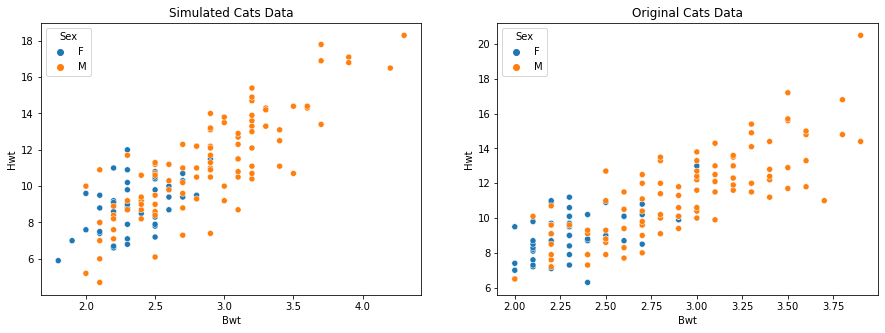

In [52]:
# sCATterplot of random bwt and hwt
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axes[0], data = all_cats_mvn, x = 'Bwt', y= 'Hwt', hue='Sex')
axes[0].set_title('Simulated Cats Data')
sns.scatterplot(ax=axes[1], data = df_cats, x = 'Bwt', y= 'Hwt', hue = 'Sex')
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/all_cats_mvn_scatter'  + current_time + '.png'
plt.savefig(path)

In [53]:
# View the correlation between body weight and heart weight
all_mvn_corr = all_cats_mvn.corr()
display_side_by_side([all_mvn_corr, orig_corr], ['Simulation Correlation', 
                                                'Original Correlation'])

,Bwt,Hwt
Bwt,1.000000,0.827563
Hwt,0.827563,1.000000
,Bwt,Hwt
Bwt,1.000000,0.804127
Hwt,0.804127,1.000000


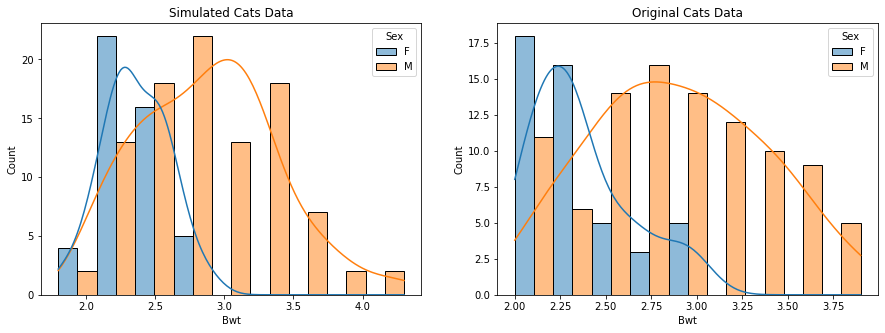

In [54]:
# Plotting the random bodyweight by sex
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data = all_cats_mvn, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True)
axes[0].set_title('Simulated Cats Data')
sns.histplot(ax=axes[1], data = df_cats, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True)
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/all_cats_mvn_hist_bwt'  + current_time + '.png'
plt.savefig(path)

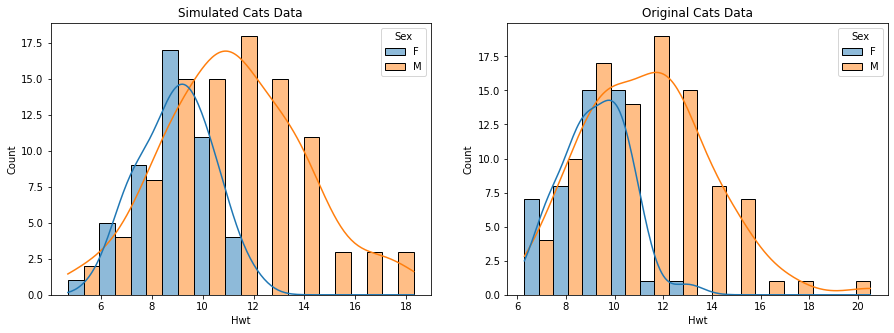

In [55]:
# Plotting the random heart weight by sex
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data = all_cats_mvn, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True)
axes[0].set_title('Simulated Cats Data')
sns.histplot(ax=axes[1], data = df_cats, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True)
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/all_cats_mvn_hist_hwt'  + current_time + '.png'
plt.savefig(path)

Based on the summary statistics and plots, the simulated data does a pretty good job of simulating the original dataset. 

-----

## Adding Additional Variable Columns<a id='h8'></a>

The dataset now needs more variables to meet the criteria for the assignment. Two new columns will now be randomly generated for the dataset. The first will be a unique ID for each sample, and the second will be to give each cat a name. A unique ID is useful for real-world data in case two subjects end up having identical variables, making it impossible to tell if they're unique datapoints or if a subject has been incorrectly added twice. A unique ID helps to solve this issue. A name column is being added to demonstrate how to generate random non-numerical data.  

In [56]:
# Variables to be used in generating the correct id numbers
count = all_cats_mvn['Bwt'].count()
possible_id = np.arange(100000,1000000)

When generating IDs, replace is set to False to ensure that an ID cannot be repeated.

In [57]:
# Generate random 6 digit IDs
cat_id = rng.choice(possible_id, size=count, replace=False)

In [58]:
# Add ID to df and move ID to be first column
all_cats_mvn['ID'] = cat_id
all_cats_mvn.drop(labels=['ID'], axis=1,inplace = True)
all_cats_mvn.insert(0, 'ID', cat_id)

In [59]:
# View the dataframe
all_cats_mvn

,ID,Sex,Bwt,Hwt
0,480953,F,2.5,8.3
1,978443,F,2.5,10.4
2,413795,F,2.5,8.5
3,872538,F,2.2,9.2
4,912009,F,2.2,9.1
...,...,...,...,...
92,272876,M,3.0,10.0
93,163728,M,2.7,12.3
94,296723,M,3.1,10.5
95,479809,M,3.5,14.4


A column of cat names will now be generated. A zip file containing a txt file with cat names was retrieved from the following reference[<sup>15</sup>](#f15).<a id='a15'></a> The txt file was manually edited to delete comma symbols which caused issues importing the file, and information in parentheses explaining the names was also deleted. Some offensive names were also manually removed, but some may have been missed. This edited txt file is included in the repository and will be used to generate random names for the cats in the random dataset.

In [60]:
# Load cat names to pandas. Changed encoding as original recorded an error
# "'utf-8' codec can't decode byte 0xda"
# https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python
cat_names = pd.read_csv('cats-dataset/CatNames.txt', names = ['Cat Names'],
                        encoding = "ISO-8859-1")

In [61]:
# Retrieve random cat names from the dataframe 
random_cat_names = rng.choice(cat_names, size=count)

In [62]:
# Add name column to dataframe
all_cats_mvn['Name'] = random_cat_names

In [63]:
# View the dataframe
all_cats_mvn

,ID,Sex,Bwt,Hwt,Name
0,480953,F,2.5,8.3,Calli
1,978443,F,2.5,10.4,Yemma-Lee
2,413795,F,2.5,8.5,Pyewackett
3,872538,F,2.2,9.2,Okee
4,912009,F,2.2,9.1,Piper Belle
...,...,...,...,...,...
92,272876,M,3.0,10.0,Amadeus
93,163728,M,2.7,12.3,Mark I love you
94,296723,M,3.1,10.5,Hedy Lammarr
95,479809,M,3.5,14.4,Kid


In [64]:
# A path to save the dataframe, using dt to create unique file names
path = 'cats-dataset/cats-random-data/cats_random_datasets/cats_random_'  + current_time + '.csv'

# Save pandas data frame to disk.
all_cats_mvn.to_csv(path)

-----

## A Function to Generate a Simulated Cats Dataset<a id='h9'></a>

We can now write a function that would allow us to quickly generate the number of random samples specified by the user.

In [65]:
# Function to generate number of random samples specified by user
# User specifies two numbers, one for each sex
def random_cat_df(females=1, males=1):
    # Unseeded to provide different random data each time              
    rng = np.random.default_rng()

    # Generate random female data based on original data statistics and user specified sample size
    mean_f = [2.359574, 9.202128]
    cov_f = [[0.07506938, 0.19791397], [0.19791397, 1.84325624]]
    female_cats = rng.multivariate_normal(mean_f, cov_f, females)
    
    # Convert random array to pandas df
    df_female = pd.DataFrame(female_cats, columns = ['Bwt', 'Hwt'])
    
    # Add a column with sex of female
    df_female['Sex'] = 'F'
    
    # Generate multivariate random data based on the original male df mean and covariance
    mean_m = [2.900000, 11.322680]
    cov_m = [[0.21854167, 0.9425], [0.9425, 6.46323024]]
    male_cats = rng.multivariate_normal(mean_m, cov_m, males)
    
    # Convert random array to pandas df
    df_male = pd.DataFrame(male_cats, columns = ['Bwt', 'Hwt'])
    
    # Add a column with sex of male
    df_male['Sex'] = 'M'
    
    # ConCAT male and female dfs
    all_cats = pd.concat([df_female, df_male])
    
    # Round the values of the random df to one decimal place as with the original dataset
    all_cats = all_cats.round(1)
    
    # Move Sex column to the front as with original dataset
    sex = all_cats['Sex']
    all_cats.drop(labels=['Sex'], axis=1,inplace = True)
    all_cats.insert(0, 'Sex', sex)
    all_cats
    
    # Variables to be used in generating the correct id numbers
    count = all_cats['Bwt'].count()
    possible_id = np.arange(100000,1000000)
        
    # Generate random 6 digit IDs
    cat_id = rng.choice(possible_id, size=count, replace=False)
    
    # Add ID to df and move ID to be first column
    all_cats['ID'] = cat_id
    all_cats.drop(labels=['ID'], axis=1,inplace = True)
    all_cats.insert(0, 'ID', cat_id)
    
    # Load cat names to pandas
    cat_names = pd.read_csv('cats-dataset/CatNames.txt', names = ['Cat Names'],
                        encoding = "ISO-8859-1")
    
    # Retrieve random cat names from the dataframe 
    random_cat_names = rng.choice(cat_names, size=count)
    
    # Add name column to dataframe
    all_cats['Name'] = random_cat_names
            
    return all_cats

In [66]:
# Test random cat df with a higher sample than the original
# User can change the number of samples generated by changing the numbers passed to female and male
function_df = random_cat_df(females=100, males=200)

In [67]:
# View the dataframe
function_df

,ID,Sex,Bwt,Hwt,Name
0,344535,F,2.1,7.3,Purrdita
1,624428,F,2.0,8.6,Stroodles
2,500448,F,2.9,10.0,Willow
3,265709,F,2.4,7.8,Mann
4,587489,F,2.0,9.3,Levi
...,...,...,...,...,...
195,943523,M,3.5,14.3,Patience
196,304370,M,2.6,10.9,Goodfella
197,218159,M,3.2,13.5,Wycliffe
198,527105,M,2.9,14.4,Cognac


In [68]:
# View summary statistics
funct_df_summ = function_df[['Bwt', 'Hwt']].describe()
display_side_by_side([funct_df_summ, orig_summ], ['Simulation Summary Statistics', 
                                                'Original Summary Statistics'])

,Bwt,Hwt
count,300.000000,300.000000
mean,2.724000,10.688333
std,0.461447,2.364827
min,1.700000,3.900000
25%,2.400000,9.075000
50%,2.700000,10.600000
75%,3.100000,12.300000
max,4.100000,17.800000
,Bwt,Hwt
count,144.000000,144.000000


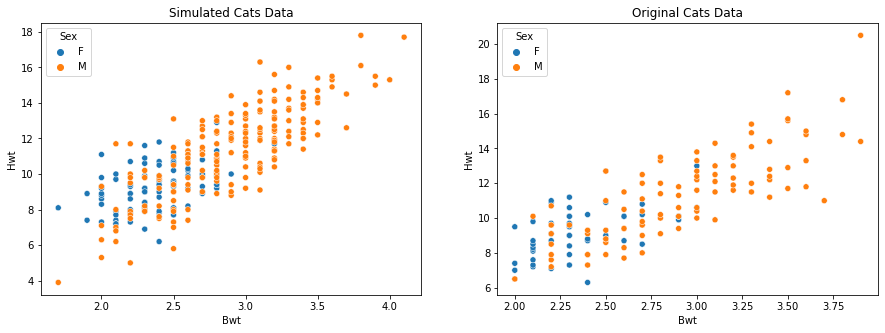

In [69]:
# sCATterplot of random function bwt and hwt
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axes[0], data = function_df, x = 'Bwt', y= 'Hwt', hue='Sex')
axes[0].set_title('Simulated Cats Data')
sns.scatterplot(ax=axes[1], data = df_cats, x = 'Bwt', y= 'Hwt', hue = 'Sex')
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/cats_random_function_scatter'  + current_time + '.png'
plt.savefig(path)

In [70]:
# View the correlation between body weight and heart weight
funct_corr = function_df[['Bwt', 'Hwt']].corr()
display_side_by_side([funct_corr, orig_corr], ['Simulation Correlation', 
                                                'Original Correlation'])

,Bwt,Hwt
Bwt,1.000000,0.805267
Hwt,0.805267,1.000000
,Bwt,Hwt
Bwt,1.000000,0.804127
Hwt,0.804127,1.000000


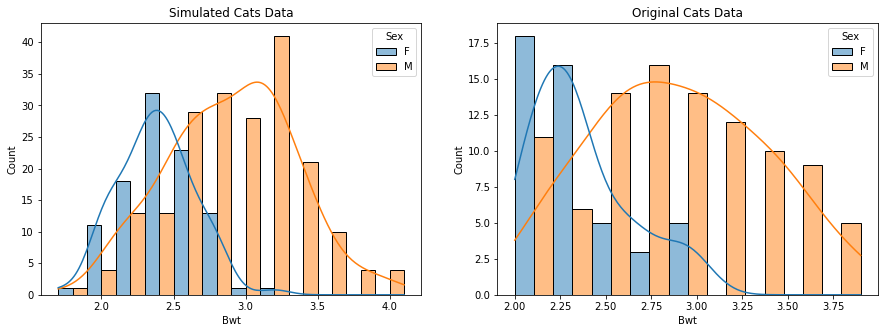

In [71]:
# Plotting the random function bodyweight by sex
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data = function_df, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True)
axes[0].set_title('Simulated Cats Data')
sns.histplot(ax=axes[1], data = df_cats, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True)
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/cats_random_function_hist_bwt'  + current_time + '.png'
plt.savefig(path)

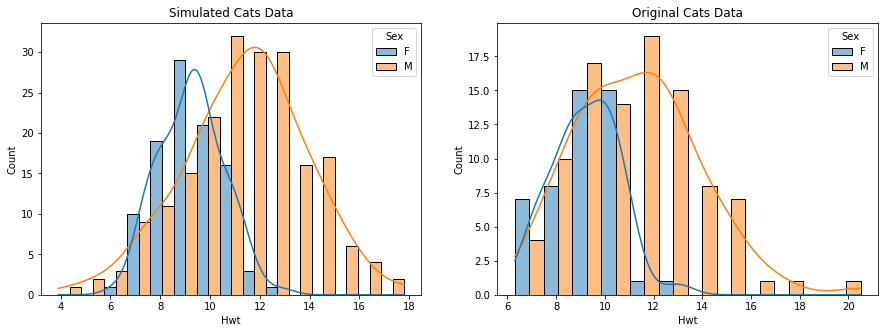

In [72]:
# Plotting the random function heart weight by sex
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data = function_df, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True)
axes[0].set_title('Simulated Cats Data')
sns.histplot(ax=axes[1], data = df_cats, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True)
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/cats_random_function_hist_hwt'  + current_time + '.png'
plt.savefig(path)

In [73]:
# A path to save the dataframe, using dt to create unique file names
path = 'cats-dataset/cats-random-data/cats_random_datasets/cats_random_function_'  + current_time + '.csv'

# Save pandas data frame to disk.
function_df.to_csv(path)

----

## Removing Underweight Samples<a id='h10'></a>

Our function returns a dataset that is similar to the original dataset, but there are some differences, most notably when it comes to cats around or under 2kg. The simulated data includes cats under 2kg, whereas in the R documentation for the original cats dataset, it states that "The cats were all adult, over 2 kg body weight". 

This may be just a coincidence and the cats from the original sample just all happened to be over 2kg, or it may be because cats under 2kg were excluded from the dataset. If it's because cats under 2kg were excluded due to some pre-existing knowledge that they cannot be validly compared with cats over 2kg, we might want to edit the above code to remove any cats that weigh under 2kg.

In [74]:
# Filter out values under 2kg
df_over_2kg = function_df[function_df['Bwt'] >= 2]

In [75]:
# View the dataframe
df_over_2kg

,ID,Sex,Bwt,Hwt,Name
0,344535,F,2.1,7.3,Purrdita
1,624428,F,2.0,8.6,Stroodles
2,500448,F,2.9,10.0,Willow
3,265709,F,2.4,7.8,Mann
4,587489,F,2.0,9.3,Levi
...,...,...,...,...,...
195,943523,M,3.5,14.3,Patience
196,304370,M,2.6,10.9,Goodfella
197,218159,M,3.2,13.5,Wycliffe
198,527105,M,2.9,14.4,Cognac


In [76]:
# View summary statistics
df_over2kg_summ = df_over_2kg[['Bwt', 'Hwt']].describe()
display_side_by_side([df_over2kg_summ, orig_summ], ['Simulation Summary Statistics', 
                                                'Original Summary Statistics'])

,Bwt,Hwt
count,296.000000,296.000000
mean,2.736486,10.737162
std,0.451611,2.332258
min,2.000000,5.000000
25%,2.400000,9.200000
50%,2.700000,10.600000
75%,3.100000,12.300000
max,4.100000,17.800000
,Bwt,Hwt
count,144.000000,144.000000


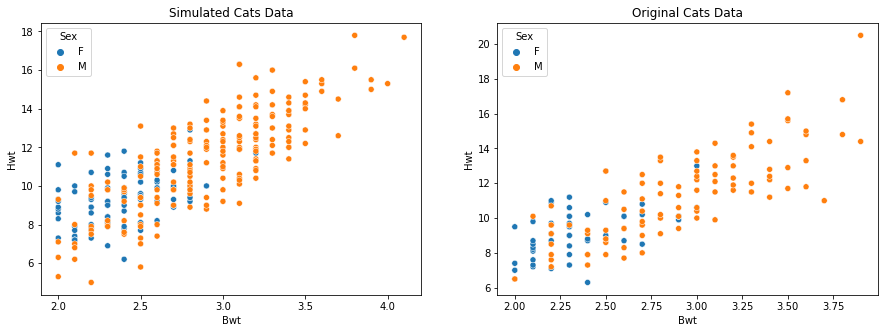

In [77]:
# sCATterplot of random function >=2kg bwt and hwt
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axes[0], data = df_over_2kg, x = 'Bwt', y= 'Hwt', hue='Sex')
axes[0].set_title('Simulated Cats Data')
sns.scatterplot(ax=axes[1], data = df_cats, x = 'Bwt', y= 'Hwt', hue = 'Sex')
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/df_over_2kg_scatter'  + current_time + '.png'
plt.savefig(path)

In [78]:
# View the correlation between body weight and heart weight
df_over_2kg[['Bwt', 'Hwt']].corr()

,Bwt,Hwt
Bwt,1.000000,0.800664
Hwt,0.800664,1.000000


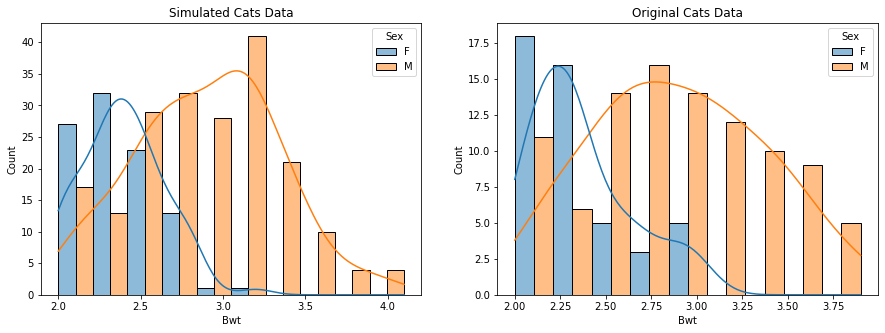

In [79]:
# Plotting the random function >=2kg bodyweight by sex
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data = df_over_2kg, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True)
axes[0].set_title('Simulated Cats Data')
sns.histplot(ax=axes[1], data = df_cats, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True)
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/df_over_2kg_hist_bwt'  + current_time + '.png'
plt.savefig(path)

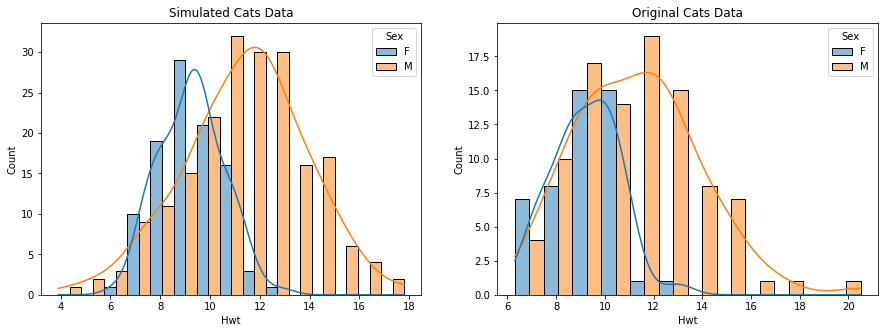

In [80]:
# Plotting the random function >=2kg heart weight by sex
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data = function_df, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True)
axes[0].set_title('Simulated Cats Data')
sns.histplot(ax=axes[1], data = df_cats, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True)
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/df_over_2kg_hist_hwt'  + current_time + '.png'
plt.savefig(path)

In [81]:
# A path to save the dataframe, using dt to create unique file names
path = 'cats-dataset/cats-random-data/cats_random_datasets/cats_random_over2kg_'  + current_time + '.csv'

# Save pandas data frame to disk.
df_over_2kg.to_csv(path)

----

## Dealing with the Truncated Distribution of Female Body Weight<a id='h11'></a>

Finally, we may wish to change the code for the female bodyweight since it failed the test for normality. Since the female body weight distribution of the original dataset is appears to be normal but truncated due to excluding subjects under 2kg in body weight we could create a new function that accounts for this. The solution includes code that was written to sample from a truncated normal distribution[<sup>16</sup>](#f16)<a id='a16'></a>, combined with an edited version of the previous function which will not return any cats that weigh under 2kg. 

Since this will be the final function that will be compared with the original dataset, the function will be seeded for reproducibility. Should a user wish to generate different random datasets they can edit the following line of code in the function ```rng = np.random.default_rng(seed=501)``` by changing the number that the seed equals to or by removing "seed=180" from between the parentheses, leaving the parentheses in place. 

In [82]:
# Function to generate the number of random samples specified by the user
# User specifies two numbers, one for each sex
# Code for female bodyweights adapted from:
# https://stackoverflow.com/questions/33590760/how-to-generate-correlated-random-numbers-for-truncated-normal-distribution-in-p
def cat_over2kg_df(females=1, males=1):         
    rng = np.random.default_rng(seed=1010)

    # convert arr_means and cov matrix to np.array
    means = np.array([2.359574, 9.202128])
    cov_matrix = np.array([[0.07506938, 0.19791397], [0.19791397, 1.84325624]])
    dimenions_bounds=np.array([[2,3],[6.3,13]])
    size = females
    
    
    # check if dimentions agree
    if not means.shape[0] == cov_matrix.shape[0]:
        raise ValueError("dimentions of means and cov matrix do not agree")
    if not cov_matrix.shape[0] == cov_matrix.shape[1]:
        raise ValueError("dimentions of means and cov matrix do not agree")

    ndims = means.shape[0]

    # if no dimenions_bounds if provided make a dimenions_bounds with np.nans
    if dimenions_bounds is None:
        dimenions_bounds = np.tile((np.nan),(ndims,2)) # make a ndims x 2 array of np.nan values
    
    
    # dimenions_bounds should be a (ndims x 2) 2d array where each row represents a dimention, 
    # and, where the first column (index=0) holds the lower bound 
    #     where the second colums (index=1) holds the upper bound
    if not dimenions_bounds.shape == (ndims,2):
        raise ValueError("dimentions of dimenions_bounds doesnt match the dimention of means")
    
    # define a local size
    local_size = size

    # create an empty array
    return_samples = np.empty([0,ndims])

    # generate new samples while the needed size is not reached
    while not return_samples.shape[0] == size:

        # get 'size' number of samples
        samples = rng.multivariate_normal(means, cov_matrix,size=local_size)

        # samples is n array of length n (as many as means, and as many as the side of the cov matrix)
        # we will stack the arrays of sample on top of each other,
        # so each row of retrun_samples is a set of n samples (each sample from one of each dimention)
        # each colums is the set of samples from one of the n dimentions

        # select only the samples that are within the upper and lower bounds for both dimentions

        # for the fist of the nd value (index = 0)

        # for each 'column' we check if the values are within the bounds of that respective column

        for dim, bounds in enumerate(dimenions_bounds):

            # keep only the samples that are bigger than the lower bound
            if not np.isnan(bounds[0]): # bounds[0] is the lower bound
                samples = samples[(samples[:,dim] > bounds[0])]  # samples[:,dim] is the column of the dim

            # keep only the samples that are smaller than the upper bound
            if not np.isnan(bounds[1]): # bounds[1] is the upper bound
                samples = samples[(samples[:,dim] < bounds[1])]   # samples[:,dim] is the column of the dim


        # input the samples into the retun samples
        return_samples = np.vstack([return_samples, samples])

        # get new size which is the difference between the requested size and the size so far.
        local_size = size - return_samples.shape[0]
    
    # return a single value when the requested size is 1 (or not specified)
    if return_samples.shape[0] == 1:
        df_female = return_samples[0]
    # otherwise 
    else:
        df_female = return_samples
    
    # Convert random array to pandas df
    df_female = pd.DataFrame(df_female, columns = ['Bwt', 'Hwt'])
    
    # Add a column with sex of female
    df_female['Sex'] = 'F'
    
    # Generate multivariate random data based on the original male df mean and covariance
    mean_m = [2.900000, 11.322680]
    cov_m = [[0.21854167, 0.9425], [0.9425, 6.46323024]]
    # Males times 2 so there will be enough samples to return when <2kg cats removed
    male_cats = rng.multivariate_normal(mean_m, cov_m, males*2)
    
    # Convert random array to pandas df
    df_male = pd.DataFrame(male_cats, columns = ['Bwt', 'Hwt'])
    
    # Add a column with sex of Male
    df_male['Sex'] = 'M'
    
    # Filter out values under 2kg
    df_male = df_male[df_male['Bwt'] >= 2]
    
    # Return the requested number of male subjects
    df_male = df_male.head(males)
    
    # ConCAT male and female dfs
    all_cats = pd.concat([df_female, df_male])
    
    # Round the values of the random df to one decimal place as with the original dataset
    all_cats = all_cats.round(1)
    
    # Move Sex column to the front as with original dataset
    sex = all_cats['Sex']
    all_cats.drop(labels=['Sex'], axis=1,inplace = True)
    all_cats.insert(0, 'Sex', sex)
    all_cats
    
    # Variables to be used in generating the correct id numbers
    count = all_cats['Bwt'].count()
    possible_id = np.arange(100000,1000000)
        
    # Generate random 6 digit IDs
    cat_id = rng.choice(possible_id, size=count, replace=False)
    
    # Add ID to df and move ID to be first column
    all_cats['ID'] = cat_id
    all_cats.drop(labels=['ID'], axis=1,inplace = True)
    all_cats.insert(0, 'ID', cat_id)
    
    # Load cat names to pandas
    cat_names = pd.read_csv('cats-dataset/CatNames.txt', names = ['Cat Names'],
                        encoding = "ISO-8859-1")
    
    # Retrieve random cat names from the dataframe 
    random_cat_names = rng.choice(cat_names, size=count)
    
    # Add name column to dataframe
    all_cats['Name'] = random_cat_names
    
            
    return all_cats

In [83]:
# Test the function to create a random sample that mimics the original
sim_df_cats = cat_over2kg_df(females=47, males=97)

In [84]:
# View the dataframe
sim_df_cats

,ID,Sex,Bwt,Hwt,Name
0,161700,F,2.2,6.9,Moglet
1,601621,F,2.1,8.9,Maule
2,736735,F,2.1,10.0,Serve
3,373301,F,2.7,9.8,Boogie Oogie Oogie
4,184787,F,2.2,7.7,Shepherd
...,...,...,...,...,...
92,675136,M,2.9,14.2,Segun
93,645433,M,2.3,8.7,Desmonda
94,135619,M,3.2,12.7,Googly
95,887043,M,2.2,9.3,Windsor


In [85]:
# View summary statistics
sim_summ = sim_df_cats[['Bwt', 'Hwt']].describe()
display_side_by_side([sim_summ, orig_summ], ['Simulation Summary Statistics', 
                                            'Original Summary Statistics'])

,Bwt,Hwt
count,144.000000,144.000000
mean,2.715972,10.600694
std,0.475360,2.430531
min,2.000000,5.100000
25%,2.300000,8.900000
50%,2.600000,10.250000
75%,3.025000,11.900000
max,4.000000,18.700000
,Bwt,Hwt
count,144.000000,144.000000


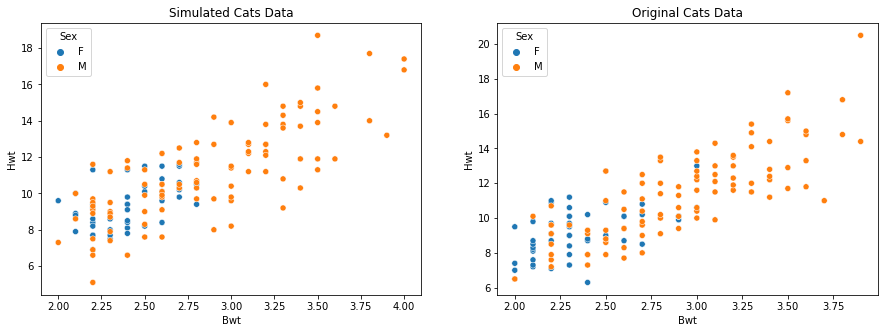

In [86]:
# sCATterplot of random function >=2kg bwt and hwt
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axes[0], data = sim_df_cats, x = 'Bwt', y= 'Hwt', hue='Sex')
axes[0].set_title('Simulated Cats Data')
sns.scatterplot(ax=axes[1], data = df_cats, x = 'Bwt', y= 'Hwt', hue = 'Sex')
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/sim_df_cats_scatter'  + current_time + '.png'
plt.savefig(path)

In [87]:
# View the correlation bewteen body weight and heart weight for all cats
sim_corr = sim_df_cats[['Bwt', 'Hwt']].corr()
display_side_by_side([sim_corr, orig_corr], ['Simulation Correlation', 
                                            'Original Correlation'])

,Bwt,Hwt
Bwt,1.000000,0.786946
Hwt,0.786946,1.000000
,Bwt,Hwt
Bwt,1.000000,0.804127
Hwt,0.804127,1.000000


In [88]:
# Get female cats from the dataframe and view summary
sim_f = sim_df_cats[sim_df_cats['Sex'] == 'F']
sim_f_summ = sim_f[['Bwt', 'Hwt']].describe()
display_side_by_side([sim_f_summ, orig_f.describe()], ['Simulation Summary Females', 
                                                        'Original Summary Females'])

,Bwt,Hwt
count,47.000000,47.000000
mean,2.410638,9.340426
std,0.213902,1.239505
min,2.000000,6.900000
25%,2.200000,8.400000
50%,2.400000,9.400000
75%,2.600000,10.150000
max,2.800000,11.600000
,Bwt,Hwt
count,47.000000,47.000000


In [89]:
# View the correlation bewteen body weight and heart weight for female cats
sim_f_corr = sim_f[['Bwt', 'Hwt']].corr()
display_side_by_side([sim_f_corr, orig_f_corr], ['Simulation Correlation Females', 
                                            'Original Correlation Females'])

,Bwt,Hwt
Bwt,1.000000,0.532120
Hwt,0.532120,1.000000
,Bwt,Hwt
Bwt,1.000000,0.532050
Hwt,0.532050,1.000000


In [90]:
# Get male cats from the dataframe and view summary
sim_m = sim_df_cats[sim_df_cats['Sex'] == 'M']
sim_m_summ = sim_m[['Bwt', 'Hwt']].describe()
display_side_by_side([sim_m_summ, orig_m.describe()], ['Simulation Summary Males', 
                                                        'Original Summary Males'])

,Bwt,Hwt
count,97.000000,97.000000
mean,2.863918,11.211340
std,0.496904,2.628524
min,2.000000,5.100000
25%,2.500000,9.500000
50%,2.800000,11.200000
75%,3.200000,12.700000
max,4.000000,18.700000
,Bwt,Hwt
count,97.000000,97.000000


In [91]:
# View the correlation bewteen body weight and heart weight for male cats
sim_m_corr = sim_m[['Bwt', 'Hwt']].corr()
display_side_by_side([sim_m_corr, orig_m_corr], ['Simulation Correlation Males', 
                                            'Original Correlation Males'])

,Bwt,Hwt
Bwt,1.000000,0.771044
Hwt,0.771044,1.000000
,Bwt,Hwt
Bwt,1.000000,0.793030
Hwt,0.793030,1.000000


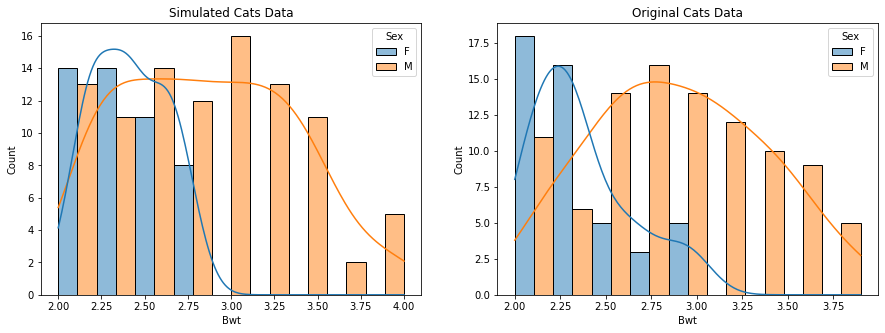

In [92]:
# Plotting the random function >=2kg bodyweight by sex
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data = sim_df_cats, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True)
axes[0].set_title('Simulated Cats Data')
sns.histplot(ax=axes[1], data = df_cats, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True)
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/sim_df_cats_hist_bwt'  + current_time + '.png'
plt.savefig(path)

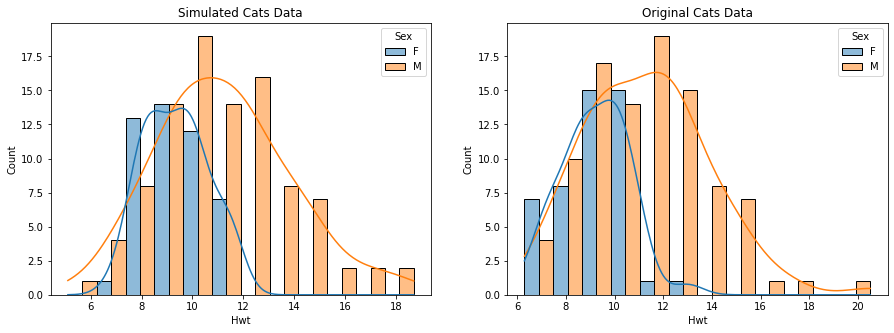

In [93]:
# Plotting the random function >=2kg heartweight by sex
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data = sim_df_cats, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True)
axes[0].set_title('Simulated Cats Data')
sns.histplot(ax=axes[1], data = df_cats, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True)
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/sim_df_cats_hist_hwt'  + current_time + '.png'
plt.savefig(path)

In [94]:
# A path to save the dataframe, using dt to create unique file names
path = 'cats-dataset/cats-random-data/cats_random_datasets/cats_random_original_size_'  + current_time + '.csv'

# Save pandas data frame to disk.
sim_df_cats.to_csv(path)

In [95]:
# Test the function to create a random sample larger than the original
sim_cats_final = cat_over2kg_df(females=150, males=300)

In [96]:
# View the dataframe
sim_cats_final

,ID,Sex,Bwt,Hwt,Name
0,773937,F,2.2,6.9,Tahiti
1,162085,F,2.1,8.9,Stubby
2,699637,F,2.1,10.0,Meowski
3,702804,F,2.7,9.8,Furari
4,108595,F,2.2,7.7,Imani
...,...,...,...,...,...
300,877901,M,2.9,11.3,Carson
301,560738,M,4.2,17.9,Bubbie
302,923407,M,2.6,5.5,Lap Kitty
303,575229,M,2.4,10.7,Thea


In [97]:
# View summary statistics
sim_summ_final = sim_cats_final[['Bwt', 'Hwt']].describe()
display_side_by_side([sim_summ_final, orig_summ], ['Simulation Summary Statistics', 
                                                   'Original Summary Statistics'])

,Bwt,Hwt
count,450.000000,450.000000
mean,2.763333,10.630000
std,0.427363,2.197197
min,2.000000,5.100000
25%,2.400000,9.000000
50%,2.700000,10.500000
75%,3.000000,11.900000
max,4.200000,17.900000
,Bwt,Hwt
count,144.000000,144.000000


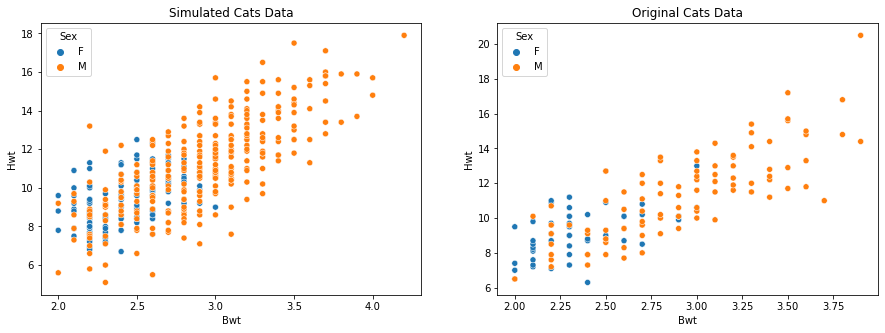

In [98]:
# sCATterplot of random function >=2kg bwt and hwt
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axes[0], data = sim_cats_final, x = 'Bwt', y= 'Hwt', hue='Sex')
axes[0].set_title('Simulated Cats Data')
sns.scatterplot(ax=axes[1], data = df_cats, x = 'Bwt', y= 'Hwt', hue = 'Sex')
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/sim_cats_final_scatter'  + current_time + '.png'
plt.savefig(path)

In [99]:
# View the correlation bewteen body weight and heart weight for all cats
sim_corr_final = sim_cats_final[['Bwt', 'Hwt']].corr()
display_side_by_side([sim_corr_final, orig_corr], ['Simulation Correlation', 
                                                   'Original Correlation'])

,Bwt,Hwt
Bwt,1.000000,0.756538
Hwt,0.756538,1.000000
,Bwt,Hwt
Bwt,1.000000,0.804127
Hwt,0.804127,1.000000


In [100]:
# Get female cats from the dataframe and view summary
sim_f_final = sim_cats_final[sim_cats_final['Sex']=='F']
sim_f_summ_final = sim_f_final[['Bwt', 'Hwt']].describe()
display_side_by_side([sim_f_summ_final, orig_f.describe()], ['Simulation Summary Females', 
                                                        'Original Summary Females'])

,Bwt,Hwt
count,150.000000,150.000000
mean,2.453333,9.452667
std,0.235354,1.254292
min,2.000000,6.700000
25%,2.200000,8.525000
50%,2.400000,9.400000
75%,2.600000,10.400000
max,3.000000,12.500000
,Bwt,Hwt
count,47.000000,47.000000


In [101]:
# View the correlation bewteen body weight and heart weight for female cats
sim_f_corr_final = sim_f_final[['Bwt', 'Hwt']].corr()
display_side_by_side([sim_f_corr_final, orig_f_corr], ['Simulation Correlation Females', 
                                                   'Original Correlation Females'])

,Bwt,Hwt
Bwt,1.000000,0.494909
Hwt,0.494909,1.000000
,Bwt,Hwt
Bwt,1.000000,0.532050
Hwt,0.532050,1.000000


In [102]:
# Get male cats from the dataframe and view summary
sim_m_final = sim_cats_final[sim_cats_final['Sex']=='M']
sim_m_summ_final = sim_m_final[['Bwt', 'Hwt']].describe()
display_side_by_side([sim_m_summ_final, orig_m.describe()], ['Simulation Summary Males', 
                                                        'Original Summary Males'])

,Bwt,Hwt
count,300.000000,300.000000
mean,2.918333,11.218667
std,0.417546,2.328632
min,2.000000,5.100000
25%,2.600000,9.700000
50%,2.900000,11.000000
75%,3.200000,12.700000
max,4.200000,17.900000
,Bwt,Hwt
count,97.000000,97.000000


In [103]:
# View the correlation bewteen body weight and heart weight for male cats
sim_m_corr_final = sim_m_final[['Bwt', 'Hwt']].corr()
display_side_by_side([sim_m_corr_final, orig_m_corr], ['Simulation Correlation Males', 
                                                   'Original Correlation Males'])

,Bwt,Hwt
Bwt,1.000000,0.739806
Hwt,0.739806,1.000000
,Bwt,Hwt
Bwt,1.000000,0.793030
Hwt,0.793030,1.000000


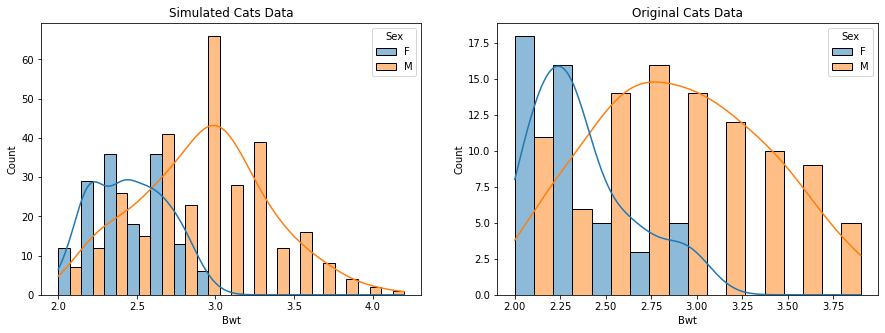

In [104]:
# Plotting the final simulated df by bodyweight
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data = sim_cats_final, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True)
axes[0].set_title('Simulated Cats Data')
sns.histplot(ax=axes[1], data = df_cats, x = 'Bwt', hue = 'Sex', multiple="dodge", kde=True)
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/sim_cats_final_hist_bwt'  + current_time + '.png'
plt.savefig(path)

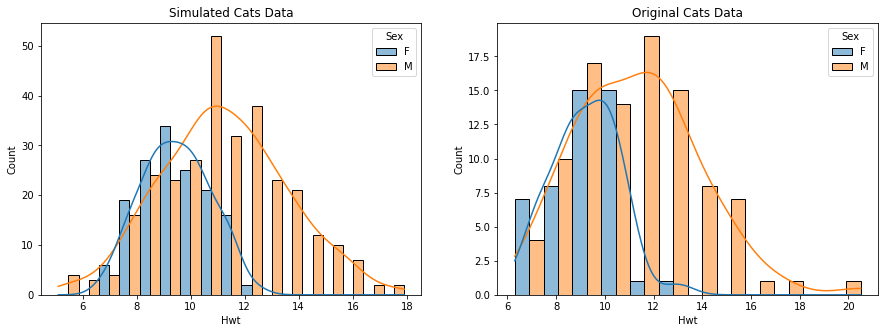

In [105]:
# Plotting the final simulated df by heartweight
# Code adapted from: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax=axes[0], data = sim_cats_final, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True)
axes[0].set_title('Simulated Cats Data')
sns.histplot(ax=axes[1], data = df_cats, x = 'Hwt', hue = 'Sex', multiple="dodge", kde=True)
axes[1].set_title('Original Cats Data')

# Save plot
path = 'cats-dataset/cats-random-data/cats_random_plots/sim_cats_final_hist_hwt'  + current_time + '.png'
plt.savefig(path)

In [106]:
# A path to save the dataframe, using dt to create unique file names
path = 'cats-dataset/cats-random-data/cats_random_datasets/cats_random_final_'  + current_time + '.csv'

# Save pandas data frame to disk.
sim_cats_final.to_csv(path)

## Conclusion<a id='h12'></a>

We now have several ways to simulate the original dataset. 

If we want to include cat weights that the original dataset excluded we can use the ```random_cat_df()``` function.   


If we want to exclude cats under 2kg and sample from a truncated normal distribution as the original seems to for female cats body weight we can use the ```cat_over2kg_df()``` function.    

# References<a id='h13'></a>
**1**.<a id='f1'></a> Fisher, R.A., 1947. The analysis of covariance method for the relation between a part and the whole. Biometrics, 3(2), pp.65-68. [online] Doi: https://doi.org/10.2307/3001641 [Accessed 03 January 2022].[↩](#a1)     
**2**.<a id='f2'></a> Kolesnikov, S., 2017. Datasets in Python. [online] Available at: <https://kolesnikov.ga/Datasets_in_Python/> [Accessed 03 January 2022].[↩](#a2)       
**3**.<a id='f3'></a> Eichhorn, E.J. and Gheorghiade, M., 2002. Digoxin. Progress in cardiovascular diseases, 44(4), pp.251-266. [online]. Doi: <https://doi.org/10.1053/pcad.2002.31591> [Accessed 03 January 2022].[↩](#a3)     
**4**.<a id='f4'></a> PETCARERX, 2021. Using Lanoxin - Heart Disease Treatment for Pets Lanoxin (Brand Name to Digoxin) Helps Cats and Dogs Who Suffer from Congestive Heart Failure [online]. Available at: <https://www.petcarerx.com/medication-guides/using-lanoxin-heart-disease-treatment-for-pets/1077> [Accessed 03 January 2022].[↩](#a4)     
**5**.<a id='f5'></a> Latto, J., 1992. The differentiation of animal body weights. Functional Ecology, pp.386-395. [online] Doi: https://doi.org/10.2307/2389276  [Accessed 03 January 2022].[↩](#a5)      
**6**.<a id='f6'></a> Pearson, K., 1895. Correlation coefficient. In Royal Society Proceedings (Vol. 58, p. 214). [online]. Available at: <https://homepages.shu.ac.uk/~edsjlc/ict/information_sources/stats/statistical%20analysis3.pdf> [Accessed 03 January 2022].[↩](#a6)      
**7**.<a id='f7'></a> Numpy, 2022. numpy.random.Generator.multivariate_normal. [online]. Available at: <https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multivariate_normal.html#numpy.random.Generator.multivariate_normal> [Accessed 03 January 2022]. [↩](#a7)     
**8**.<a id='f8'></a> Kaplan, R.M. and Berry, C.C., 1990. Adjusting for confounding variables. Research methodology: Strengthening causal interpretations of nonexperimental data, pp.105-114. [↩](#a8)     
**9**.<a id='f9'></a> BMJ, 2020. 2. Mean and standard deviation. [online] Available at: <https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/2-mean-and-standard-deviation> [Accessed 03 January 2022].[↩](#a9)   
**10**.<a id='f10'></a> Shapiro, S.S. and Wilk, M.B., 1965. An analysis of variance test for normality (complete samples). Biometrika, 52(3/4), pp.591-611. [online]. Doi: https://doi.org/10.2307/2333709  [Accessed 03 January 2022].[↩](#a10)     
**11**.<a id='f11'></a> scipy, 2022. scipy.stats.shapiro. [online]. Available at: <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html> [Accessed 03 January 2022].[↩](#a11)    
**12**.<a id='f12'></a> Mishra, P., Pandey, C.M., Singh, U., Gupta, A., Sahu, C. and Keshri, A., 2019. Descriptive statistics and normality tests for statistical data. Annals of cardiac anaesthesia, 22(1), p.67.
[online] Doi: 10.4103/aca.ACA_157_18 [Accessed 03 January 2022].[↩](#a12)     
**13**.<a id='f13'></a> Brownlee, J., 2019. How to Transform Data to Better Fit The Normal Distribution. [online]. Available at: https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/ [Accessed 03 January 2022]. [↩](#a13)      
**14**.<a id='f14'></a> Stephanie, 2016. What is a Truncated Distribution?. [online]. Available at: <https://www.statisticshowto.com/truncated-normal-distribution/> [Accessed 03 January 2022].[↩](#a14)      
**15**.<a id='f15'></a> kessels.com, 2008. Cat Names. [online]. Available at: <https://www.kessels.com/CatNames/> [Accessed 03 January 2022].[↩](#a15)      
**16**.<a id='f16'></a> Andre, 2021. How to generate correlated random numbers for truncated normal distribution in Python?. [online]. Available at: https://stackoverflow.com/questions/33590760/how-to-generate-correlated-random-numbers-for-truncated-normal-distribution-in-p [Accessed 03 January 2022].[↩](#a16)      
